Autores / authors:
Àlex Domínguez Rodriguez i Haroon Rehman Faciaben

Estudio de precios sobre dataset de AirBnB Barcelona a traves de diferentes modelos IA

dataset link: https://www.kaggle.com/datasets/nartexyu/barcelona-airbnb-data/data


In [392]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
)

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from yellowbrick.regressor import prediction_error
from skopt import BayesSearchCV

np.int = int  

warnings.filterwarnings("ignore")

In [394]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'Test Score'] = clf.best_score_
    else:
        df.loc[nclf,'Test Score'] = np.nan
    df.loc[nclf, 'R2 Score'] = r2_score(y_test, clf.predict(X_test))
    df.loc[nclf, 'Squared Error'] = mean_squared_error(y_test, clf.predict(X_test))
    df.loc[nclf, 'Absolute Error'] = mean_absolute_error(y_test, clf.predict(X_test))
    return df

results_df = pd.DataFrame()

niter = 15
cv = 10
seed = 42

In [395]:
data_all = pd.read_csv("datasets/listings_barcelona.csv")
data_all.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13977576,https://www.airbnb.com/rooms/13977576,20230314070701,2023-03-14,previous scrape,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,...,NaN,NaN,NaN,NaN,f,1,0,1,0,0.01
1,42105584,https://www.airbnb.com/rooms/42105584,20230314070701,2023-03-14,previous scrape,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,...,NaN,NaN,NaN,Exempt,f,1,0,1,0,NaN
2,33727898,https://www.airbnb.com/rooms/33727898,20230314070701,2023-03-14,city scrape,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,...,5.0,4.83,4.73,HUTB-008684,f,4,4,0,0,0.63


In [396]:
data_all.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,15655.0,NaN,NaN,NaN,182338517577503232.0,312664092521369664.0,18674.0,18918164.0,38641402.0,556374819426612608.0,846230032385844096.0
listing_url,15655,15655,https://www.airbnb.com/rooms/13977576,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scrape_id,15655.0,NaN,NaN,NaN,20230314070697.730469,3.269636,20230314070701.0,20230314070701.0,20230314070701.0,20230314070701.0,20230314070701.0
last_scraped,15655,2,2023-03-14,15640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,15655,2,city scrape,12647,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
calculated_host_listings_count,15655.0,NaN,NaN,NaN,24.163462,46.16822,1.0,1.0,5.0,23.0,241.0
calculated_host_listings_count_entire_homes,15655.0,NaN,NaN,NaN,21.14251,45.881018,0.0,0.0,2.0,19.0,241.0
calculated_host_listings_count_private_rooms,15655.0,NaN,NaN,NaN,2.856404,11.617766,0.0,0.0,0.0,1.0,120.0
calculated_host_listings_count_shared_rooms,15655.0,NaN,NaN,NaN,0.084063,0.789422,0.0,0.0,0.0,0.0,12.0


In [397]:
data_all.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

# ELIMINACION DE ATRIBUTOS

In [398]:
data_all.drop(['id',
               'host_id',
               'listing_url',
               'scrape_id',
               'last_scraped',
               'source',
               'name',
               'description',
               'neighborhood_overview',
               'picture_url',
               'host_url',
               'host_name',
               'host_since',
               'host_location',
               'host_about',
               'host_response_time',
               'host_thumbnail_url',
               'host_picture_url',
               'host_neighbourhood',
               'host_has_profile_pic',
               'host_identity_verified',
               'minimum_minimum_nights',
               'maximum_minimum_nights',
               'minimum_maximum_nights', 
               'maximum_maximum_nights',
               'minimum_nights_avg_ntm',
               'maximum_nights_avg_ntm',
               'calculated_host_listings_count',
               'calculated_host_listings_count_entire_homes',
               'calculated_host_listings_count_private_rooms',
               'calculated_host_listings_count_shared_rooms',
               'first_review', 
               'last_review'], axis = 1, inplace = True)

data_all.head(3)
print("De los 75 atributos iniciales, nos quedamos con {}.".format(data_all.shape[1]))

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month
0,NaN,NaN,f,1.0,1.0,"['email', 'phone']",NaN,Hostafrancs,Sants-Montjuïc,41.37254,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,0.01
1,NaN,NaN,f,1.0,2.0,"['email', 'phone']",NaN,la Prosperitat,Nou Barris,41.43948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,NaN
2,100%,92%,t,4.0,4.0,"['email', 'phone']","Barcelona, Catalunya, Spain",Sant Antoni,Eixample,41.37585,...,5.0,4.97,4.97,5.0,5.0,4.83,4.73,HUTB-008684,f,0.63


De los 75 atributos iniciales, nos quedamos con 42.


In [399]:
data_all.drop(['neighbourhood',
               'neighbourhood_cleansed'],
              axis = 1, inplace = True)

data_all.head(3)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,neighbourhood_group_cleansed,latitude,longitude,property_type,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month
0,NaN,NaN,f,1.0,1.0,"['email', 'phone']",Sants-Montjuïc,41.37254,2.14485,Private room in rental unit,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,0.01
1,NaN,NaN,f,1.0,2.0,"['email', 'phone']",Nou Barris,41.43948,2.17810,Private room in rental unit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,NaN
2,100%,92%,t,4.0,4.0,"['email', 'phone']",Eixample,41.37585,2.15412,Entire rental unit,...,5.0,4.97,4.97,5.0,5.0,4.83,4.73,HUTB-008684,f,0.63


In [400]:
data_all.drop(['latitude', 
             'longitude',
               'amenities',
               'license'
            ], axis = 1, inplace = True)
data_all.head(3)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,neighbourhood_group_cleansed,property_type,room_type,accommodates,...,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,NaN,NaN,f,1.0,1.0,"['email', 'phone']",Sants-Montjuïc,Private room in rental unit,Private room,1,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,f,0.01
1,NaN,NaN,f,1.0,2.0,"['email', 'phone']",Nou Barris,Private room in rental unit,Private room,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
2,100%,92%,t,4.0,4.0,"['email', 'phone']",Eixample,Entire rental unit,Entire home/apt,5,...,1,5.0,4.97,4.97,5.0,5.0,4.83,4.73,f,0.63


In [401]:
data_all.drop(['host_response_rate', 
               'host_acceptance_rate',
               'host_is_superhost',
               'host_listings_count',
               'host_total_listings_count',
               'host_verifications',
               'calendar_last_scraped',
               'calendar_updated'],
              axis = 1, inplace = True)
data_all.head(3)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,...,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,Sants-Montjuïc,Private room in rental unit,Private room,1,NaN,1 bath,1.0,1.0,$12.00,1,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,f,0.01
1,Nou Barris,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1.0,$25.00,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN
2,Eixample,Entire rental unit,Entire home/apt,5,NaN,1.5 baths,3.0,5.0,$300.00,4,...,1,5.0,4.97,4.97,5.0,5.0,4.83,4.73,f,0.63


In [402]:
data_all.property_type.unique()

array(['Private room in rental unit', 'Entire rental unit',
       'Private room in hostel', 'Private room in condo',
       'Entire serviced apartment', 'Room in serviced apartment',
       'Room in hotel', 'Entire condo', 'Private room in home',
       'Entire loft', 'Room in boutique hotel', 'Private room',
       'Entire home', 'Private room in townhouse', 'Entire guest suite',
       'Room in hostel', 'Shared room in hostel', 'Entire guesthouse',
       'Camper/RV', 'Entire villa', 'Private room in bed and breakfast',
       'Private room in guesthouse', 'Private room in guest suite',
       'Shared room in home', 'Shared room in loft',
       'Private room in vacation home',
       'Private room in serviced apartment', 'Casa particular',
       'Shared room in guest suite', 'Private room in casa particular',
       'Shared room in rental unit', 'Room in aparthotel',
       'Room in bed and breakfast', 'Entire townhouse',
       'Shared room in boutique hotel', 'Houseboat', 'Share

In [403]:
data_all.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [404]:
data_all.drop(['property_type'], axis = 1, inplace = True)

# REINTERPRETACION DE ATRIBUTOS

In [405]:
data_all.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,15655,10,Eixample,5691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_type,15655,4,Entire home/apt,9463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,15655.0,NaN,NaN,NaN,3.48451,2.172102,0.0,2.0,3.0,4.0,16.0
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms_text,15647,37,1 bath,6336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,15098.0,NaN,NaN,NaN,1.758511,1.051358,1.0,1.0,1.0,2.0,20.0
beds,15378.0,NaN,NaN,NaN,2.443101,1.862454,1.0,1.0,2.0,3.0,30.0
price,15655,653,$50.00,428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minimum_nights,15655.0,NaN,NaN,NaN,14.712807,39.934269,1.0,1.0,3.0,31.0,1125.0
maximum_nights,15655.0,NaN,NaN,NaN,616.003258,461.7814,1.0,190.0,365.0,1125.0,3000.0


In [406]:
data_all['price'] = data_all['price'].replace('[\$,]', '', regex=True).astype(float)

In [407]:
data_all['instant_bookable'] = data_all['instant_bookable'].map({'f': False, 't': True})

In [408]:
data_all['has_availability'] = data_all['has_availability'].map({'f': False, 't': True})

In [409]:
data_all.isna().sum()

neighbourhood_group_cleansed        0
room_type                           0
accommodates                        0
bathrooms                       15655
bathrooms_text                      8
bedrooms                          557
beds                              277
price                               0
minimum_nights                      0
maximum_nights                      0
has_availability                    0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
number_of_reviews_ltm               0
number_of_reviews_l30d              0
review_scores_rating             3479
review_scores_accuracy           3567
review_scores_cleanliness        3566
review_scores_checkin            3571
review_scores_communication      3565
review_scores_location           3571
review_scores_value              3570
instant_bookable                    0
reviews_per_

In [410]:
# Crear columnas vacías en el DataFrame
data_all['shared_bathroom'] = False
data_all['bathrooms'] = None

# Llenar las nuevas columnas basadas en el atributo bathrooms_text
for i, bathrooms_text in enumerate(data_all['bathrooms_text'].astype(str).str.lower()):
    n_bathrooms = None

    if bathrooms_text != 'nan':
        if 'half' in bathrooms_text:
            n_bathrooms = 0.5
        else:
            # Utiliza una expresión regular para extraer el número de baños
            match = re.search(r'\d+\.*\d*', bathrooms_text)
            if match:
                n_bathrooms = float(match.group())

        # Asignar el valor a la columna 'bathrooms' para la fila actual
        data_all.at[i, 'bathrooms'] = n_bathrooms

        # Verificar si 'shared' está presente en bathrooms_text
        if 'shared' in bathrooms_text:
            data_all.at[i, 'shared_bathroom'] = True
    else:   
        barrio_actual = data_all.at[i, 'neighbourhood_group_cleansed']
        media_bathrooms_por_barrio = data_all[data_all['neighbourhood_group_cleansed'] == barrio_actual]['bathrooms'].mean()

        data_all.at[i, 'bathrooms'] = round(media_bathrooms_por_barrio)
        data_all.at[i, 'shared_bathroom'] = False
data_all['bathrooms'] = data_all['bathrooms'].astype(float)
print(data_all['bathrooms'].unique())

[ 1.   1.5  5.   2.   4.   3.5  3.   2.5  6.   0.   8.   0.5 11.  10.
  4.5 13.   5.5  7.   7.5 12. ]


In [411]:
data_all.drop(['bathrooms_text'], axis = 1, inplace = True)

In [412]:
# Calcula la media por barrio para las columnas 'beds' y 'bedrooms'
media_por_barrio = data_all.groupby('neighbourhood_group_cleansed')[['beds', 'bedrooms']].mean()

# Itera sobre las filas del DataFrame
for index, row in data_all.iterrows():
    # Verifica si el valor en 'beds' es NaN
    if pd.isna(row['beds']):
        # Reemplaza el valor NaN por la media redondeada en función del accomodates
        data_all.at[index, 'beds'] = media_por_barrio.loc[row['neighbourhood_group_cleansed'], 'beds']

    # Verifica si el valor en 'bedrooms' es NaN
    if pd.isna(row['bedrooms']):
        # Reemplaza el valor NaN por la media redondeada en función del barrio
        data_all.at[index, 'bedrooms'] = media_por_barrio.loc[row['neighbourhood_group_cleansed'], 'bedrooms']

In [413]:
print(data_all.shape)
# Elimina todas las filas que contienen valores NaN
data_all_cleaned = data_all.dropna()

# Verifica el resultado
print(data_all_cleaned.shape)

(15655, 27)
(12082, 27)


(<Figure size 1000x800 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

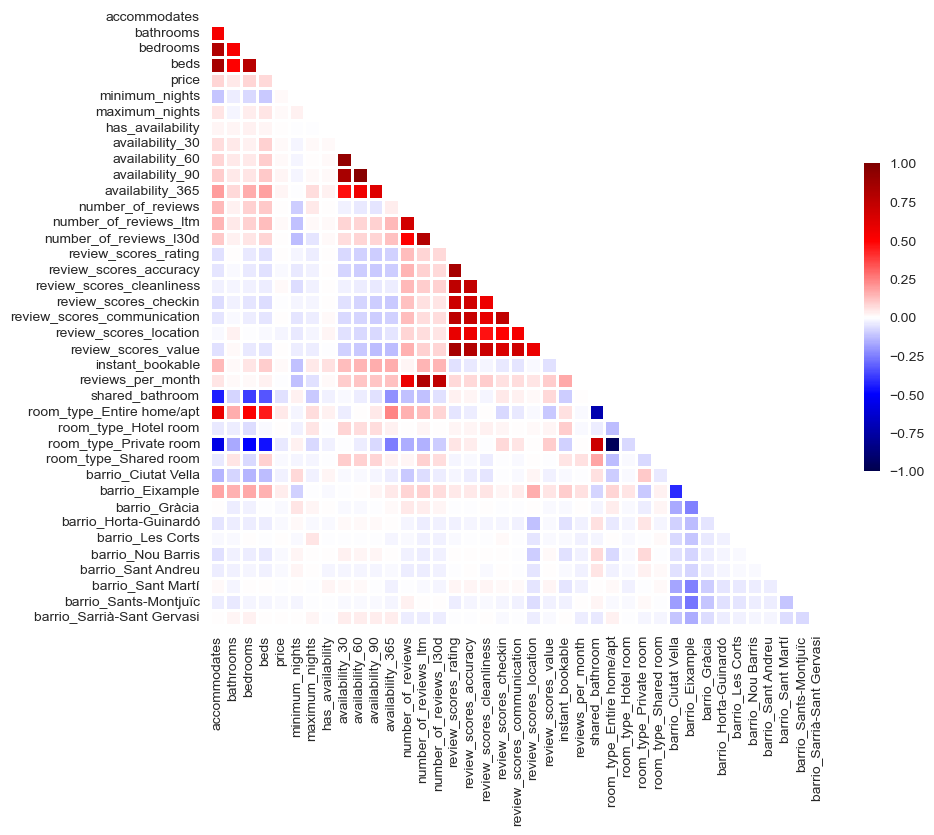

In [414]:
data_all_cleaned.rename(columns={'neighbourhood_group_cleansed': 'barrio'},inplace = True)
data_encoded = pd.get_dummies(data_all_cleaned, columns=['room_type','barrio'])

# Matriz de correlación
corr = data_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic', center=0, square=True, linewidths=1, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

In [415]:
media_por_barrio = data_all_cleaned.groupby('barrio')['price'].mean()
print(media_por_barrio)

barrio
Ciutat Vella           111.573615
Eixample               195.495546
Gràcia                 129.249771
Horta-Guinardó          95.436950
Les Corts              173.350000
Nou Barris              65.168000
Sant Andreu             61.704545
Sant Martí             145.317857
Sants-Montjuïc         131.246933
Sarrià-Sant Gervasi    174.271805
Name: price, dtype: float64


In [416]:
max_por_barrio = data_all_cleaned.groupby('barrio')['price'].max()
print(max_por_barrio)

barrio
Ciutat Vella            6075.0
Eixample               90000.0
Gràcia                  4044.0
Horta-Guinardó          1837.0
Les Corts               9100.0
Nou Barris              1457.0
Sant Andreu              275.0
Sant Martí             14098.0
Sants-Montjuïc         25811.0
Sarrià-Sant Gervasi    11000.0
Name: price, dtype: float64


In [417]:
min_por_barrio = data_all_cleaned.groupby('barrio')['price'].min()
print(min_por_barrio)

barrio
Ciutat Vella           10.0
Eixample                9.0
Gràcia                 10.0
Horta-Guinardó          9.0
Les Corts              14.0
Nou Barris             10.0
Sant Andreu            14.0
Sant Martí             10.0
Sants-Montjuïc          9.0
Sarrià-Sant Gervasi    15.0
Name: price, dtype: float64


# Estudiar la previsión de precios para el barrio de l'Eixample con varios modelos

In [418]:
# Eliminar los outliers
print(len(data_encoded[data_encoded['price'] > 600])/len(data_encoded) * 100, "% de los datos tienen un precio mayor a 600€")

1.1918556530375766 % de los datos tienen un precio mayor a 600€


In [419]:
list_drop_atributes = []
for c in data_encoded.columns:
    if 'barrio' in c and not 'Eixample' in c:
        list_drop_atributes.append(c)

data_encoded_600 = data_encoded[data_encoded.price <= 600]
data_eixample = data_encoded_600.drop(list_drop_atributes, axis = 1)
data_eixample = data_eixample[data_eixample.barrio_Eixample == 1]
data_eixample.drop('barrio_Eixample', axis = 1, inplace = True)

In [420]:
data_eixample.head(3)
data_eixample.isna().sum()

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,shared_bathroom,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
2,5,1.5,3.0,5.0,300.0,4,30,True,22,48,...,5.00,4.83,4.73,False,0.63,False,1,0,0,0
3,1,1.0,1.0,1.0,83.0,1,1125,True,3,21,...,4.64,4.91,4.73,True,0.69,False,0,0,1,0
6,5,1.0,2.0,4.0,93.0,3,365,True,5,10,...,4.80,5.00,5.00,True,2.34,False,1,0,0,0


accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
price                          0
minimum_nights                 0
maximum_nights                 0
has_availability               0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
reviews_per_month              0
shared_bathroom                0
room_type_Entire home/apt      0
room_type_Hotel room           0
room_type_Private room         0
room_type_Shared room          0
dtype: int64

In [421]:
data_eixample.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
accommodates,4415.0,NaN,NaN,NaN,4.060702,2.357576,1.0,2.0,4.0,6.0,16.0
bathrooms,4415.0,NaN,NaN,NaN,1.453228,0.678843,0.0,1.0,1.0,2.0,11.0
bedrooms,4415.0,NaN,NaN,NaN,1.966613,1.073241,1.0,1.0,2.0,3.0,9.0
beds,4415.0,NaN,NaN,NaN,2.853838,2.041882,1.0,1.0,2.0,4.0,26.0
price,4415.0,NaN,NaN,NaN,155.887203,109.411531,9.0,70.0,138.0,203.0,600.0
minimum_nights,4415.0,NaN,NaN,NaN,8.428766,17.000915,1.0,1.0,2.0,4.0,365.0
maximum_nights,4415.0,NaN,NaN,NaN,631.894904,473.512668,2.0,180.0,365.0,1125.0,1125.0
has_availability,4415,2,True,4391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availability_30,4415.0,NaN,NaN,NaN,7.262514,8.027292,0.0,0.0,5.0,11.0,30.0
availability_60,4415.0,NaN,NaN,NaN,17.443715,16.793529,0.0,3.0,13.0,28.0,60.0


In [422]:
X = data_eixample.loc[:,data_eixample.columns!='price']
y = data_eixample.loc[:,'price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [423]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

<AxesSubplot:xlabel='accommodates', ylabel='price'>

Text(0.5, 1.0, 'accommodates vs. Price')

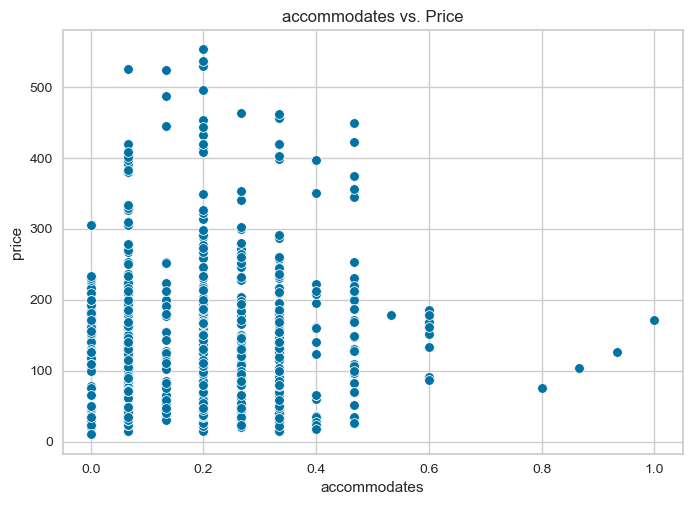

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

Text(0.5, 1.0, 'bathrooms vs. Price')

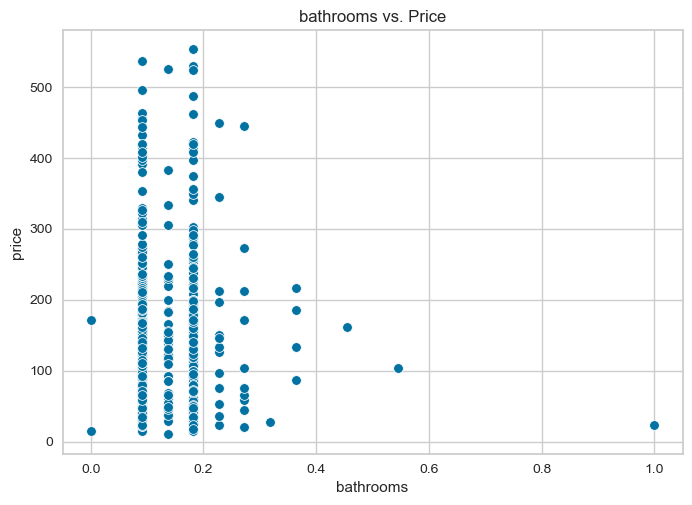

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

Text(0.5, 1.0, 'bedrooms vs. Price')

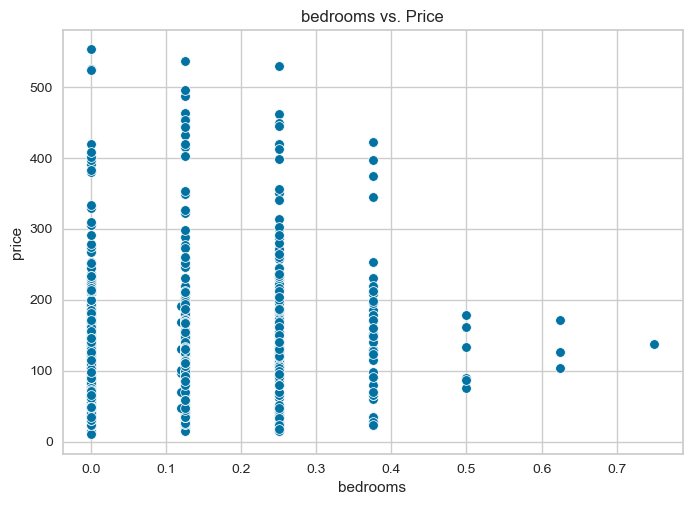

<AxesSubplot:xlabel='beds', ylabel='price'>

Text(0.5, 1.0, 'beds vs. Price')

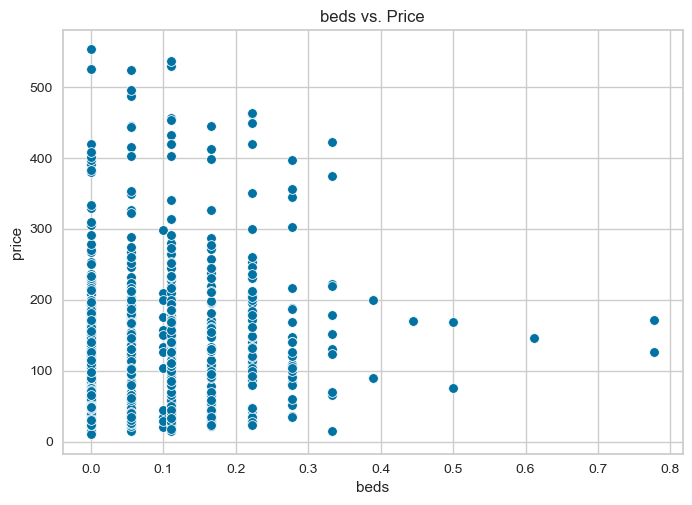

<AxesSubplot:xlabel='minimum_nights', ylabel='price'>

Text(0.5, 1.0, 'minimum_nights vs. Price')

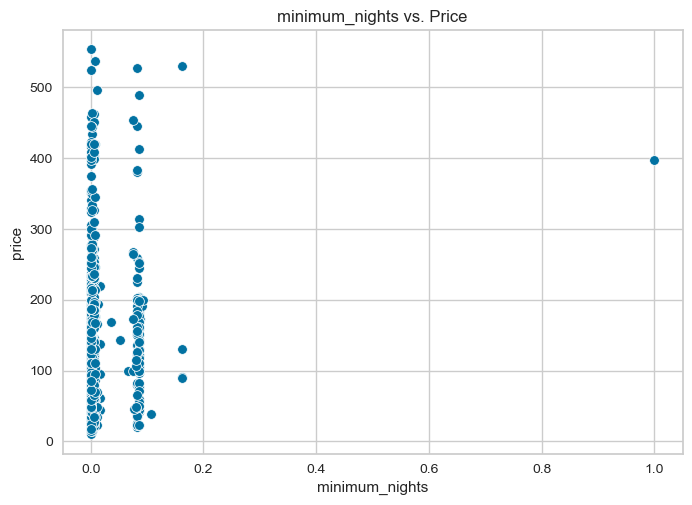

<AxesSubplot:xlabel='maximum_nights', ylabel='price'>

Text(0.5, 1.0, 'maximum_nights vs. Price')

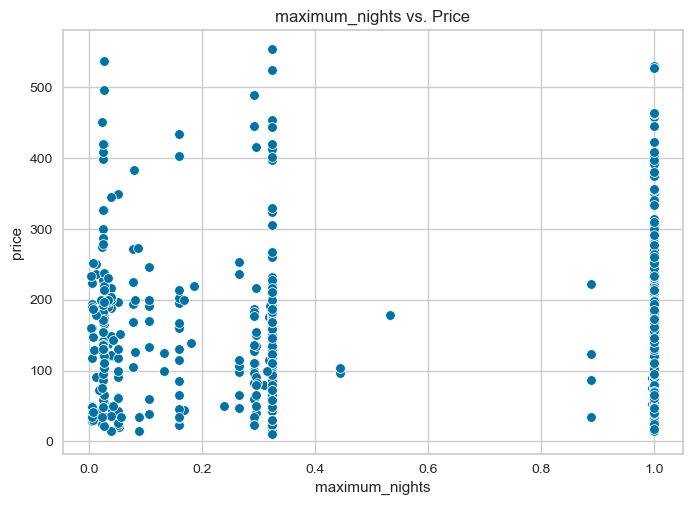

<AxesSubplot:xlabel='has_availability', ylabel='price'>

Text(0.5, 1.0, 'has_availability vs. Price')

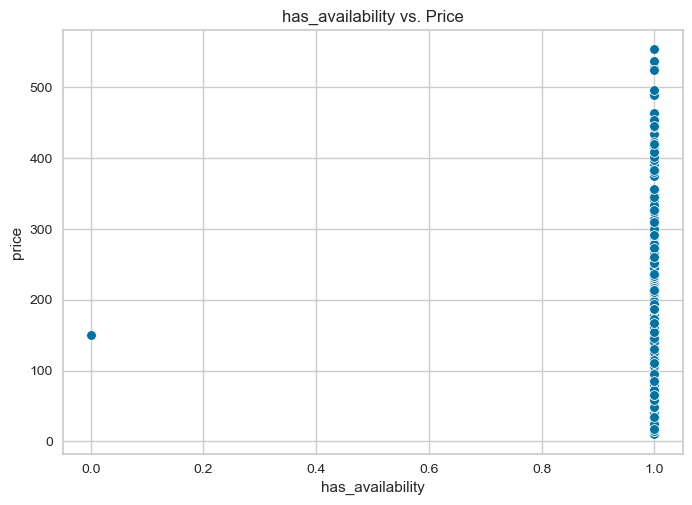

<AxesSubplot:xlabel='availability_30', ylabel='price'>

Text(0.5, 1.0, 'availability_30 vs. Price')

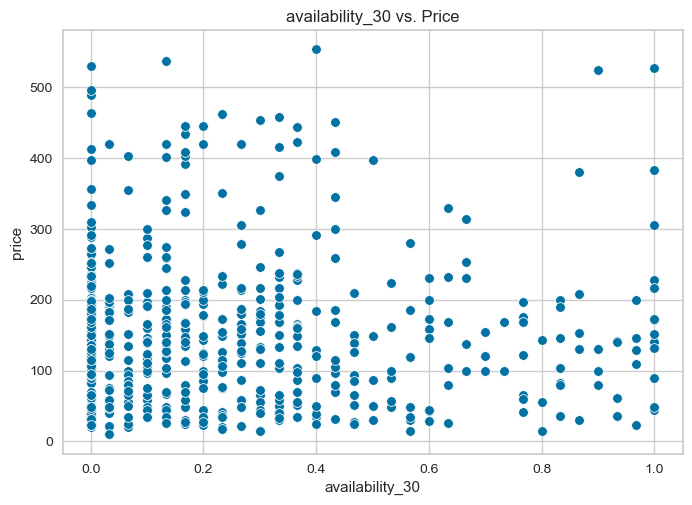

<AxesSubplot:xlabel='availability_60', ylabel='price'>

Text(0.5, 1.0, 'availability_60 vs. Price')

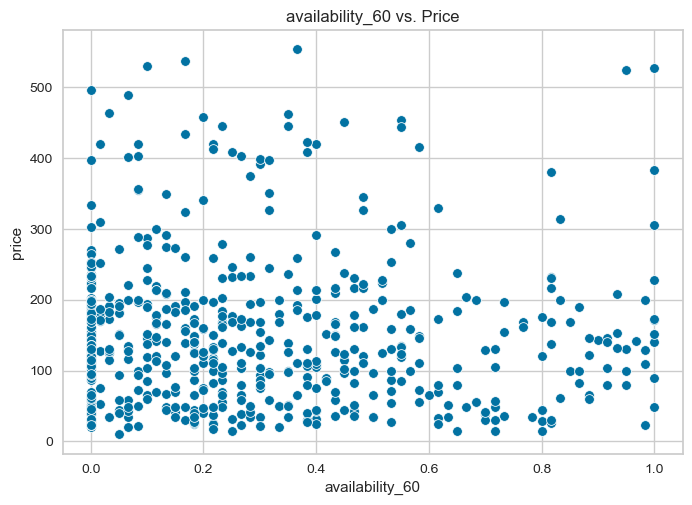

<AxesSubplot:xlabel='availability_90', ylabel='price'>

Text(0.5, 1.0, 'availability_90 vs. Price')

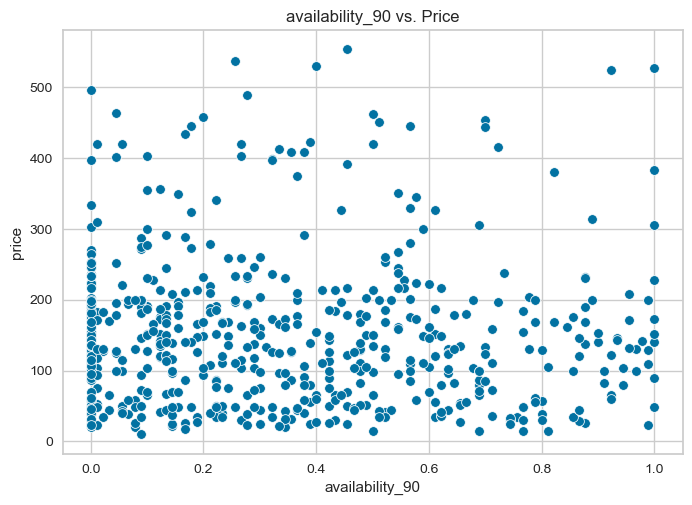

<AxesSubplot:xlabel='availability_365', ylabel='price'>

Text(0.5, 1.0, 'availability_365 vs. Price')

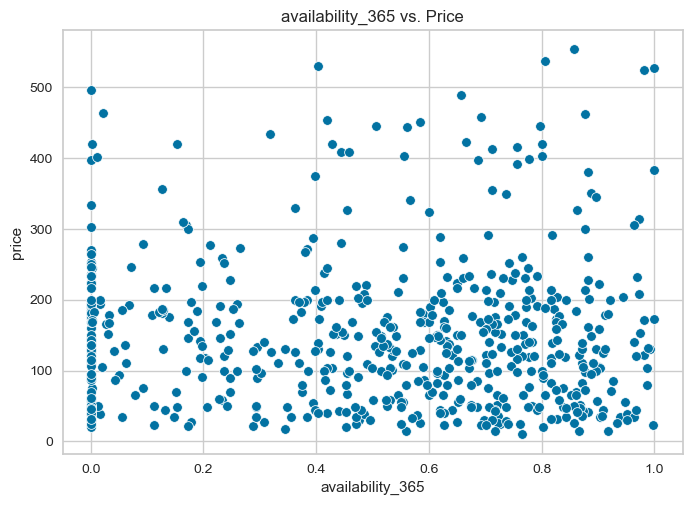

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

Text(0.5, 1.0, 'number_of_reviews vs. Price')

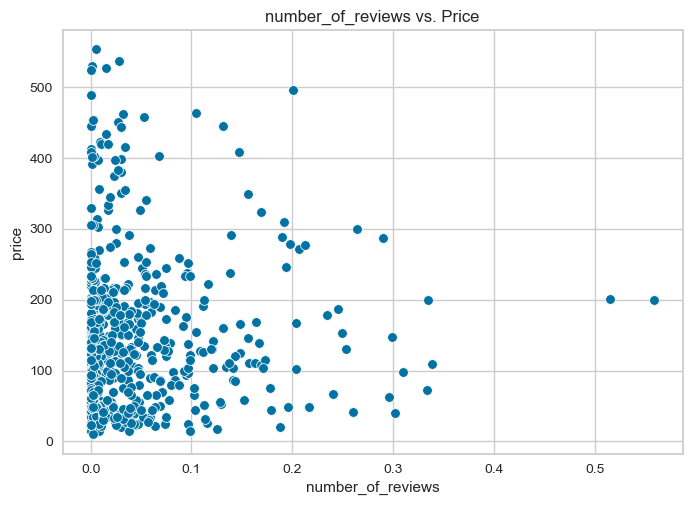

<AxesSubplot:xlabel='number_of_reviews_ltm', ylabel='price'>

Text(0.5, 1.0, 'number_of_reviews_ltm vs. Price')

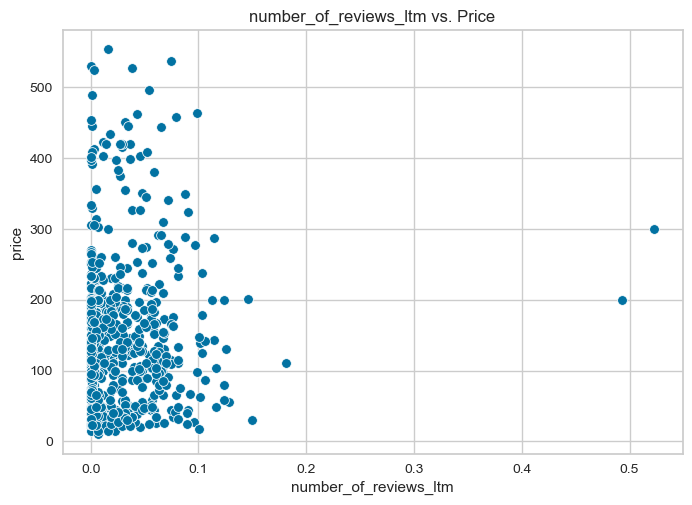

<AxesSubplot:xlabel='number_of_reviews_l30d', ylabel='price'>

Text(0.5, 1.0, 'number_of_reviews_l30d vs. Price')

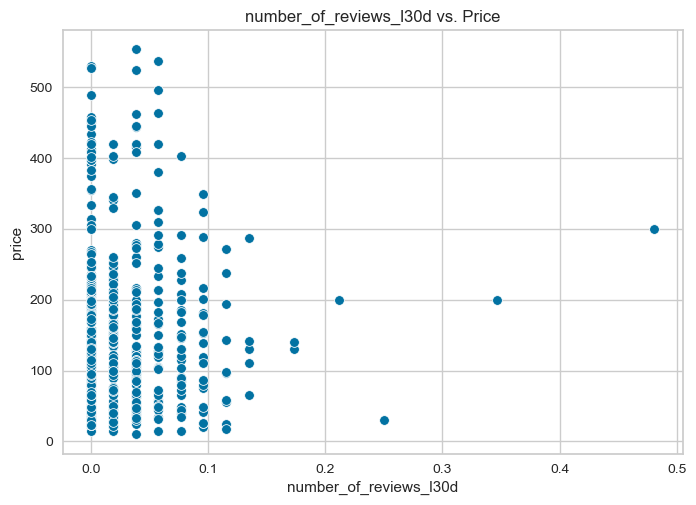

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

Text(0.5, 1.0, 'review_scores_rating vs. Price')

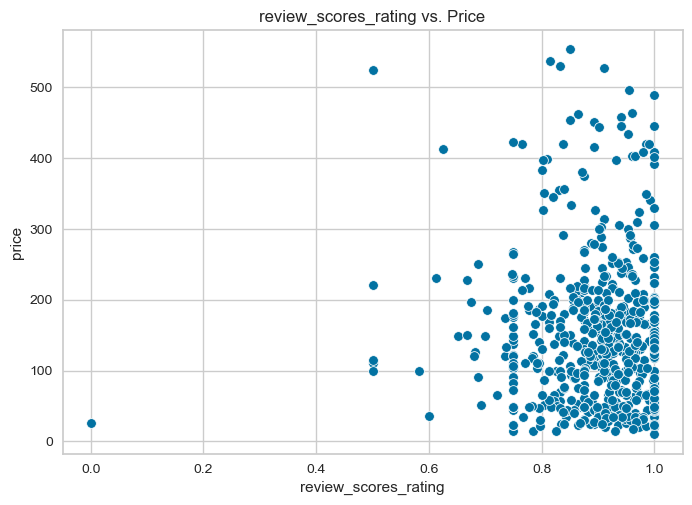

<AxesSubplot:xlabel='review_scores_accuracy', ylabel='price'>

Text(0.5, 1.0, 'review_scores_accuracy vs. Price')

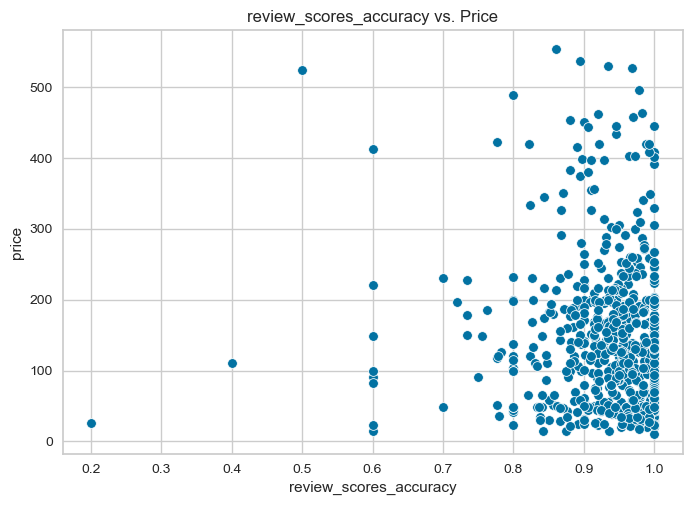

<AxesSubplot:xlabel='review_scores_cleanliness', ylabel='price'>

Text(0.5, 1.0, 'review_scores_cleanliness vs. Price')

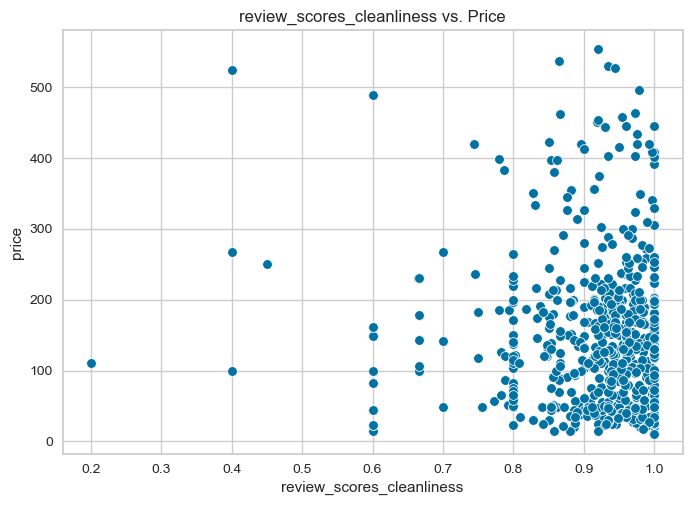

<AxesSubplot:xlabel='review_scores_checkin', ylabel='price'>

Text(0.5, 1.0, 'review_scores_checkin vs. Price')

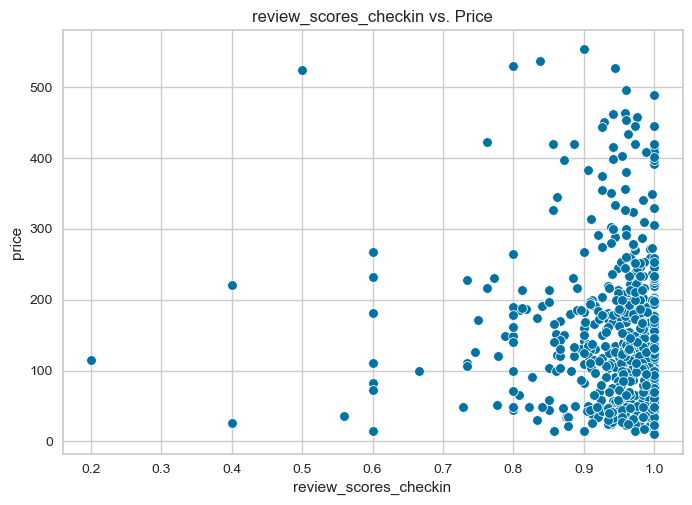

<AxesSubplot:xlabel='review_scores_communication', ylabel='price'>

Text(0.5, 1.0, 'review_scores_communication vs. Price')

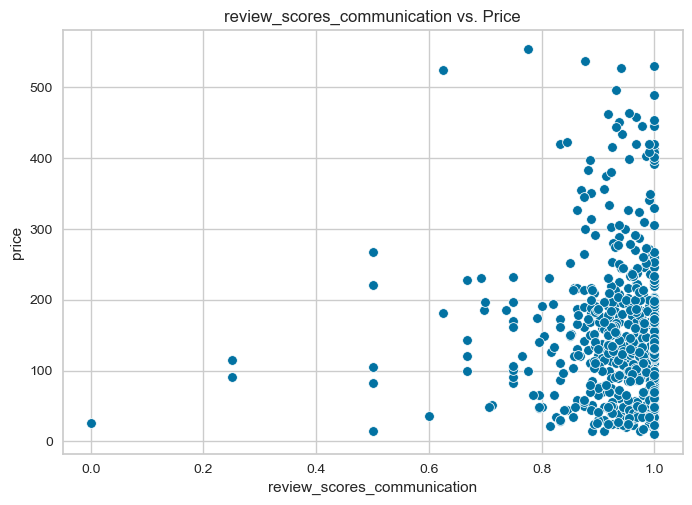

<AxesSubplot:xlabel='review_scores_location', ylabel='price'>

Text(0.5, 1.0, 'review_scores_location vs. Price')

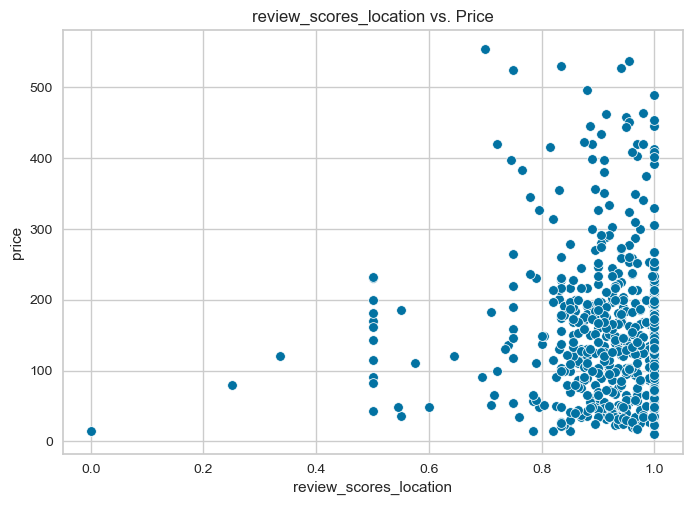

<AxesSubplot:xlabel='review_scores_value', ylabel='price'>

Text(0.5, 1.0, 'review_scores_value vs. Price')

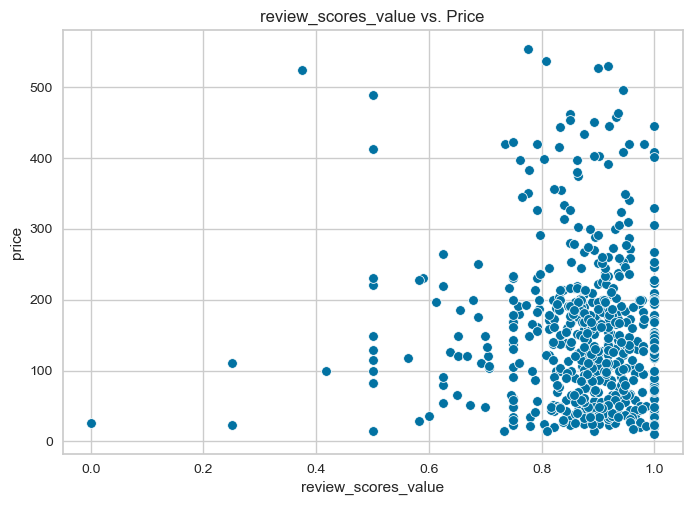

<AxesSubplot:xlabel='instant_bookable', ylabel='price'>

Text(0.5, 1.0, 'instant_bookable vs. Price')

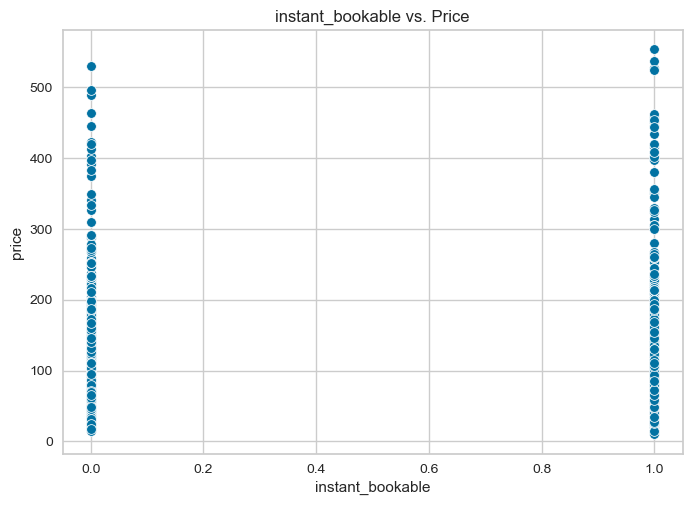

<AxesSubplot:xlabel='reviews_per_month', ylabel='price'>

Text(0.5, 1.0, 'reviews_per_month vs. Price')

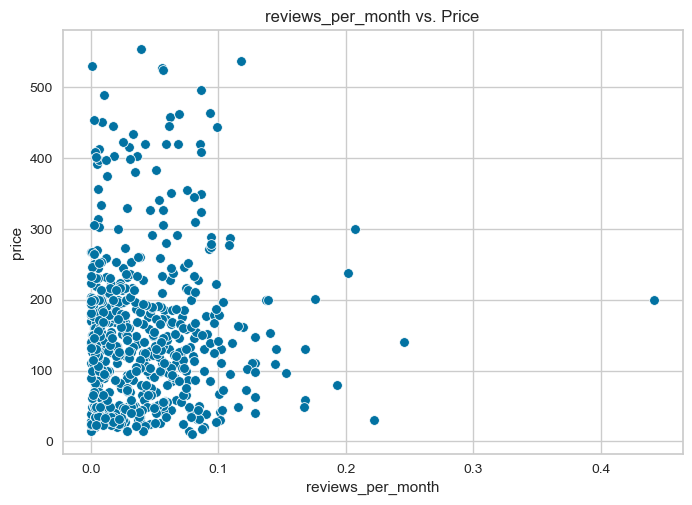

<AxesSubplot:xlabel='shared_bathroom', ylabel='price'>

Text(0.5, 1.0, 'shared_bathroom vs. Price')

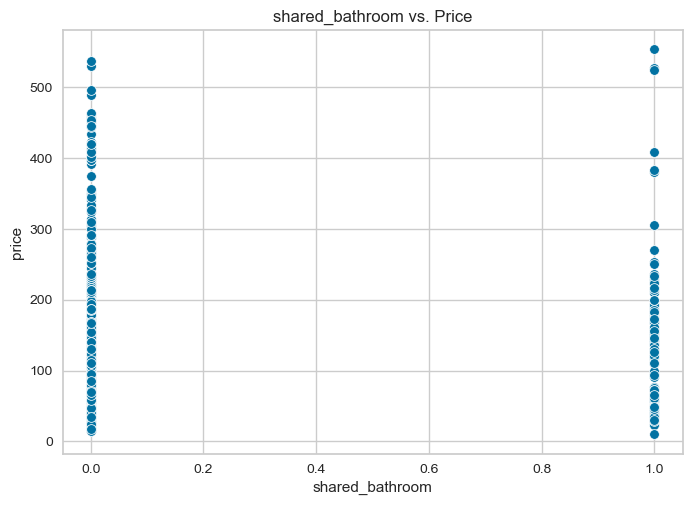

<AxesSubplot:xlabel='room_type_Entire home/apt', ylabel='price'>

Text(0.5, 1.0, 'room_type_Entire home/apt vs. Price')

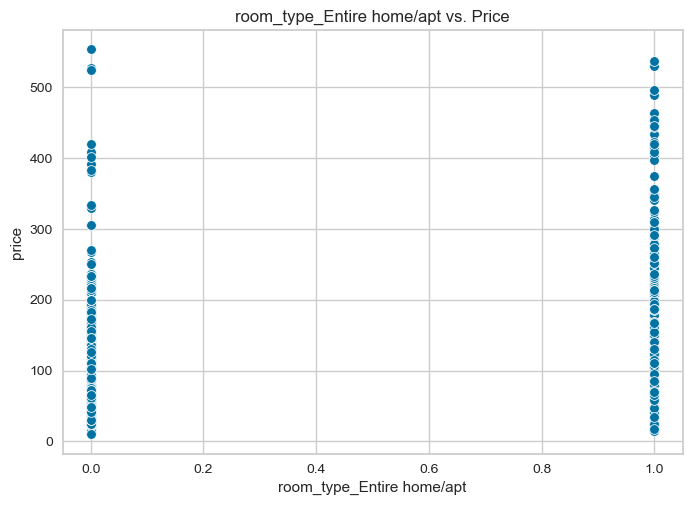

<AxesSubplot:xlabel='room_type_Hotel room', ylabel='price'>

Text(0.5, 1.0, 'room_type_Hotel room vs. Price')

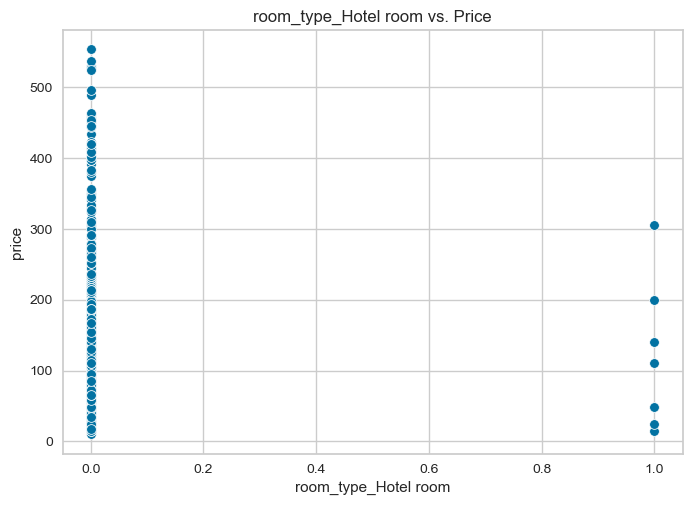

<AxesSubplot:xlabel='room_type_Private room', ylabel='price'>

Text(0.5, 1.0, 'room_type_Private room vs. Price')

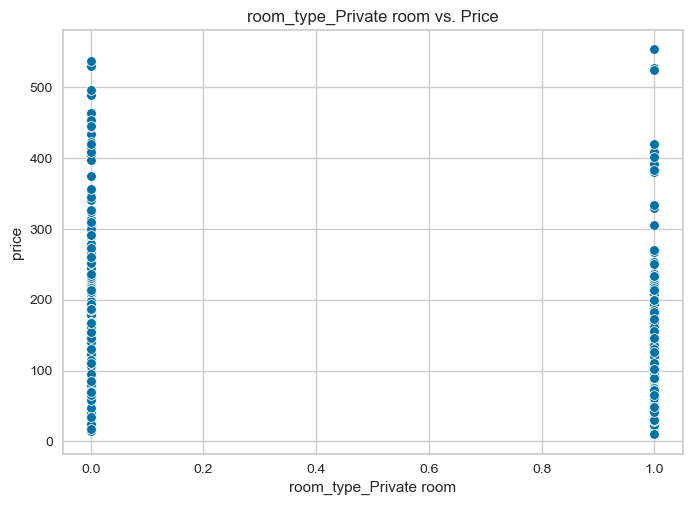

<AxesSubplot:xlabel='room_type_Shared room', ylabel='price'>

Text(0.5, 1.0, 'room_type_Shared room vs. Price')

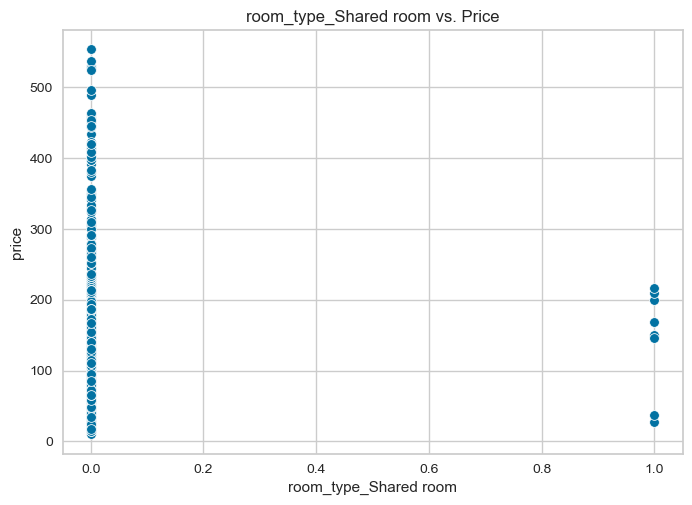

In [424]:
# Convierte el array de numpy de entrenamiento a un DataFrame
X_train_df = pd.DataFrame(X_train_s, columns=X.columns)

# Especifica las columnas numéricas que deseas visualizar
numeric_columns = X_train_df.select_dtypes(include=['float64', 'int64']).columns

# Realiza gráficos de dispersión para cada variable numérica respecto a la variable objetivo
for column in numeric_columns:
    sns.scatterplot(x=X_train_df[column], y=y_train)
    plt.title(f'{column} vs. Price')
    plt.show()

In [425]:
# K-Nearest Neighbors
knn = KNeighborsRegressor()
param_knn = {'n_neighbors': [1, 3, 5, 7, 11, 15]}
knn_gs = BayesSearchCV(knn,param_knn,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
knn_gs.fit(X_train_s, y_train)

BayesSearchCV(cv=10, estimator=KNeighborsRegressor(), n_iter=15, n_jobs=-1,
              random_state=0,
              search_spaces={'n_neighbors': [1, 3, 5, 7, 11, 15]})

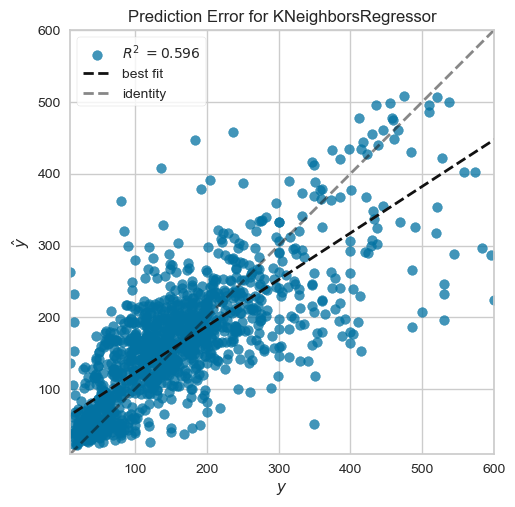

In [426]:
knn_gs_visualizer = prediction_error(knn_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test)

In [427]:
results_df = save_results(knn_gs, X_test_s, y_test, 'K-Nearest Neighbors', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
K-Nearest Neighbors,0.56469,0.596415,4696.245006,46.505768


In [428]:
param_svml = {'C':10**np.linspace(-3,3,101)}
lsvc = SVR(kernel='linear', max_iter=250000, cache_size=2000)
lsvc_gs = BayesSearchCV(lsvc,param_svml,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train_s, y_train)

/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=250000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/alexdominguez/opt/anaconda3/l

BayesSearchCV(cv=10,
              estimator=SVR(cache_size=2000, kernel='linear', max_iter=250000),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [429]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,{'C': 660.6934480075951},0.490206,1
5,{'C': 109.64781961431851},0.489987,2
13,{'C': 72.44359600749891},0.489537,3
12,{'C': 54.954087385762485},0.489007,4
14,{'C': 15.848931924611142},0.479208,5


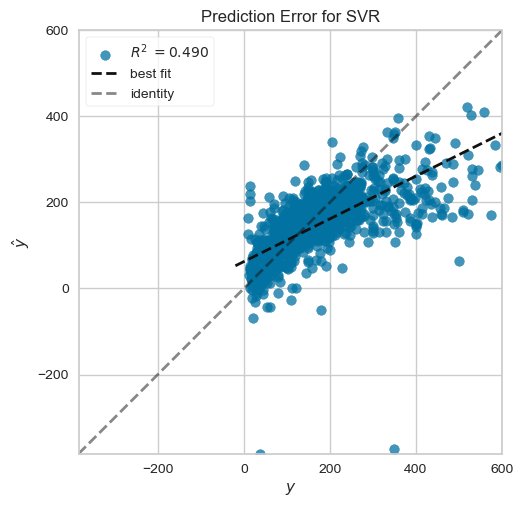

In [430]:
lsvc_visualizer = prediction_error(lsvc_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test)

In [431]:
results_df = save_results(lsvc_gs, X_test_s, y_test, 'SVM lineal', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM lineal,0.490206,0.490278,5931.291293,48.466157


In [432]:
param_svmp = {'C':10**np.linspace(-3,3,101), 'degree':[2]}
psvc = SVR(kernel='poly', max_iter=250000, cache_size=2000)
psvc_gs = BayesSearchCV(psvc,param_svmp,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0);
psvc_gs.fit(X_train_s, y_train);

In [433]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,"{'C': 660.6934480075951, 'degree': 2}",0.561426,1
11,"{'C': 380.1893963205613, 'degree': 2}",0.555075,2
10,"{'C': 331.13112148259074, 'degree': 2}",0.552699,3
13,"{'C': 125.89254117941661, 'degree': 2}",0.533450,4
5,"{'C': 109.64781961431851, 'degree': 2}",0.531116,5


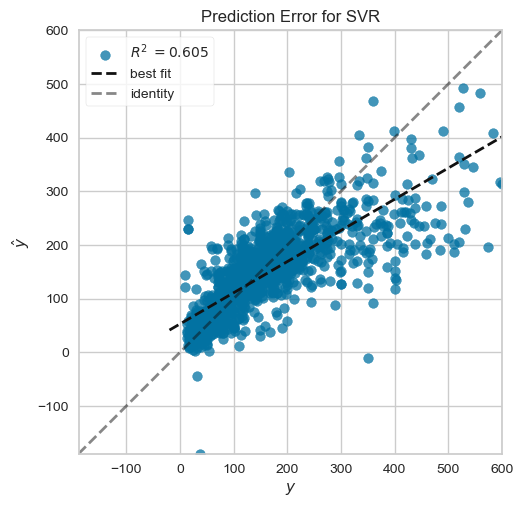

In [434]:
psvc_visualizer = prediction_error(psvc_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test);

In [435]:
results_df = save_results(psvc_gs, X_test_s, y_test, 'SVM cuadratico', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM cuadratico,0.561426,0.605028,4596.017360,42.988894
SVM lineal,0.490206,0.490278,5931.291293,48.466157


In [436]:
param_rf = {'max_depth':[None, 1, 2, 3,  5,  8, 9, 10, 15],
          'max_features': ['log2', 'sqrt'],
          'min_samples_leaf':[1,2,3,5,10],
          'n_estimators': [5,10,25,40, 50, 75,100, 200]}

rf =  RandomForestRegressor(random_state=seed)
rf_gs =  BayesSearchCV(rf,param_rf,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_gs.fit(X_train, y_train)

BayesSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]})

In [437]:
show_html(pd.DataFrame(rf_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100}",0.684072,1
5,"{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 40}",0.659275,2
6,"{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 10}",0.650545,3
13,"{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 40}",0.646743,4
14,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 10}",0.642317,5


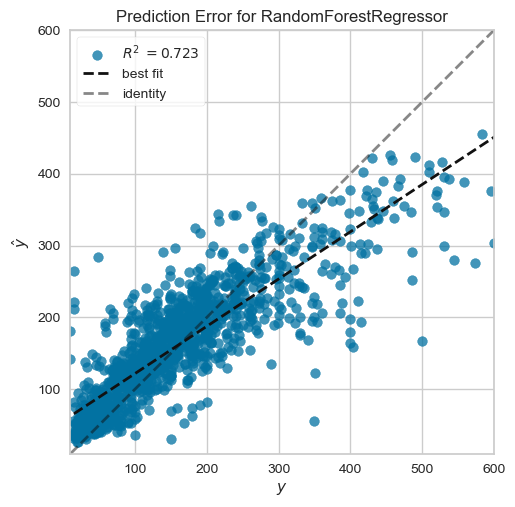

In [438]:
rf_visualizer = prediction_error(rf_gs.best_estimator_, X_train, y_train, X_test, y_test);

In [439]:
results_df = save_results(rf_gs, X_test, y_test, 'Random Forest', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
Random Forest,0.684072,0.722790,3225.703735,38.672822
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM cuadratico,0.561426,0.605028,4596.017360,42.988894
SVM lineal,0.490206,0.490278,5931.291293,48.466157


In [440]:
param_gb = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
        'learning_rate':[0.1,0.5, 1,3, 5, 10, 15],
        'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
        'subsample':[.5,.75,1],
        'loss':['squared_error', 'absolute_error']}

gb =  GradientBoostingRegressor(random_state=seed,n_iter_no_change=5)
gb_gs =  BayesSearchCV(gb,param_gb,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
gb_gs.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=GradientBoostingRegressor(n_iter_no_change=5,
                                                  random_state=42),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'learning_rate': [0.1, 0.5, 1, 3, 5, 10, 15],
                             'loss': ['squared_error', 'absolute_error'],
                             'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200],
                             'subsample': [0.5, 0.75, 1]})

In [441]:
show_html(pd.DataFrame(gb_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 40, 'subsample': 1.0}",0.651285,1
11,"{'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 25, 'subsample': 1.0}",0.615930,2
12,"{'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 25, 'subsample': 1.0}",0.615930,2
13,"{'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 40, 'subsample': 1.0}",0.615896,4
14,"{'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 40, 'subsample': 1.0}",0.615896,4


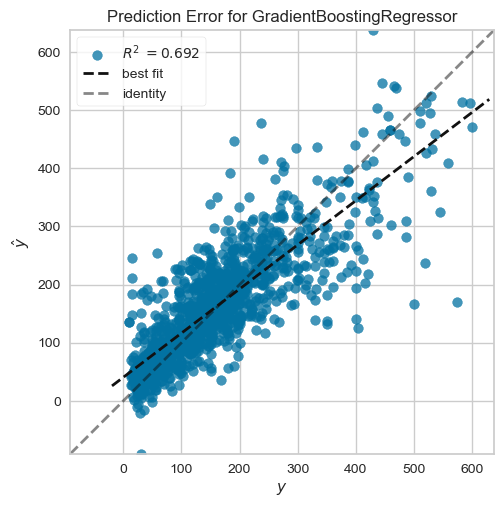

In [442]:
gb_gs_visualizer = prediction_error(gb_gs.best_estimator_, X_train, y_train, X_test, y_test)

In [443]:
results_df = save_results(gb_gs, X_test, y_test, 'Gradient Boosting', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
Random Forest,0.684072,0.722790,3225.703735,38.672822
Gradient Boosting,0.651285,0.692204,3581.609332,40.837924
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM cuadratico,0.561426,0.605028,4596.017360,42.988894
SVM lineal,0.490206,0.490278,5931.291293,48.466157


In [444]:
# SVM
param_rbf = {'C': 10**np.linspace(-3, 3, 101), 'gamma': ['scale', 'auto']}
rbf = SVR(kernel='rbf', max_iter=50000, cache_size=2000)
rbf_gs = BayesSearchCV(rbf,param_rbf,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbf_gs.fit(X_train_s, y_train)

BayesSearchCV(cv=10, estimator=SVR(cache_size=2000, max_iter=50000), n_iter=15,
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-0...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'gamma': ['scale', 'auto']})

In [445]:
show_html(pd.DataFrame(rbf_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,"{'C': 660.6934480075951, 'gamma': 'scale'}",0.606702,1
11,"{'C': 660.6934480075951, 'gamma': 'scale'}",0.606702,1
5,"{'C': 109.64781961431851, 'gamma': 'scale'}",0.546767,3
10,"{'C': 660.6934480075951, 'gamma': 'auto'}",0.520548,4
13,"{'C': 109.64781961431851, 'gamma': 'auto'}",0.486078,5


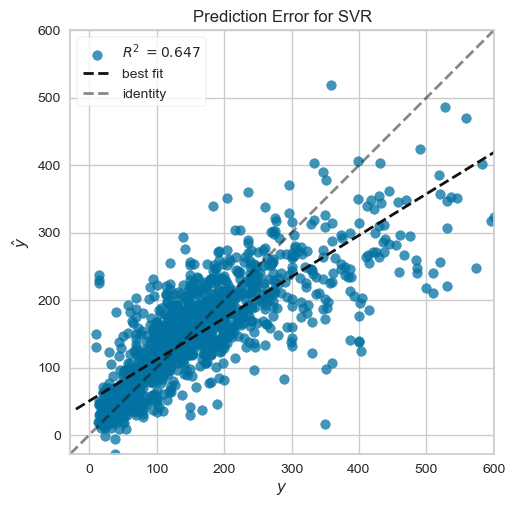

In [446]:
rbf_gs_visualizer = prediction_error(rbf_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test)

In [447]:
results_df = save_results(rbf_gs, X_test_s, y_test, 'SVM Regression with Kernel RBF', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
Random Forest,0.684072,0.722790,3225.703735,38.672822
Gradient Boosting,0.651285,0.692204,3581.609332,40.837924
SVM Regression with Kernel RBF,0.606702,0.647041,4107.139902,41.526226
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM cuadratico,0.561426,0.605028,4596.017360,42.988894
SVM lineal,0.490206,0.490278,5931.291293,48.466157


<Figure size 1000x500 with 0 Axes>

<BarContainer object of 28 artists>

Text(0.5, 0, 'Características')

Text(0, 0.5, 'Importancia de Permutación para k-NN')

Text(0.5, 1.0, 'Importancia de Permutación de Características para RF')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

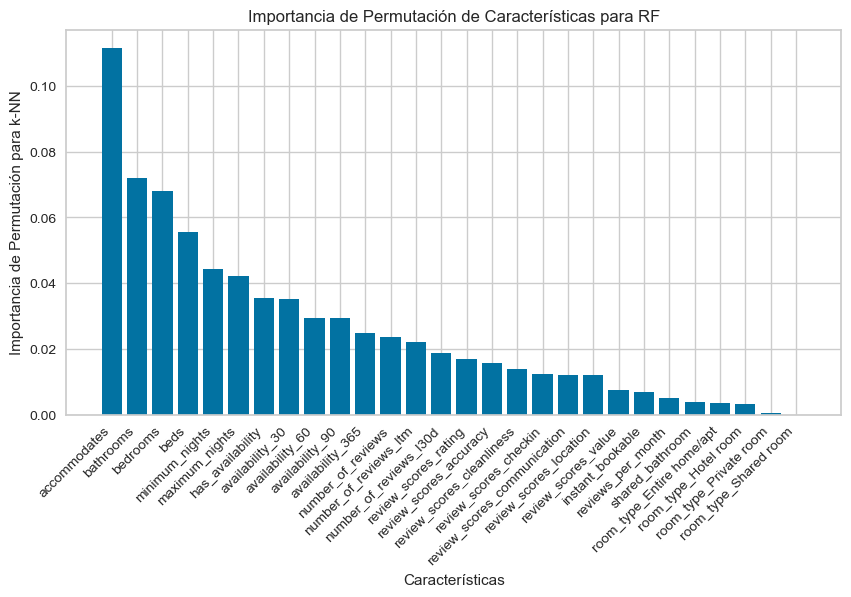

In [448]:
# Importancia de permutación para KNN
perm_importance_rf = permutation_importance(rf_gs, X_test, y_test, n_repeats=30, random_state=seed, n_jobs=-1)
perm_importance_rf_sort = importances = np.sort(perm_importance_rf['importances_mean'])[::-1]

# Visualización de la importancia de permutación para KNN
plt.figure(figsize=(10, 5))
plt.bar(X.columns, perm_importance_rf_sort)
plt.xlabel('Características')
plt.ylabel('Importancia de Permutación para k-NN')
plt.title('Importancia de Permutación de Características para RF')
plt.xticks(rotation=45, ha='right')
plt.show()

# Usar Random Forest para todos los barrios

In [450]:
X = data_encoded_600.loc[:,data_encoded_600.columns!='price']
y = data_encoded_600.loc[:,'price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [451]:
param_rf = {'max_depth':[None, 1, 2, 3,  5,  8, 9, 10, 15],
          'max_features': ['log2', 'sqrt'],
          'min_samples_leaf':[1,2,3,5,10],
          'n_estimators': [5,10,25,40, 50, 75,100, 200]}

rf =  RandomForestRegressor(random_state=seed)
rf_gs =  BayesSearchCV(rf,param_rf,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0);
rf_gs.fit(X_train, y_train)

BayesSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]})

In [452]:
show_html(pd.DataFrame(rf_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}",0.693231,1
14,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50}",0.684350,2
12,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 10}",0.658425,3
5,"{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 40}",0.652128,4
6,"{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 10}",0.650220,5


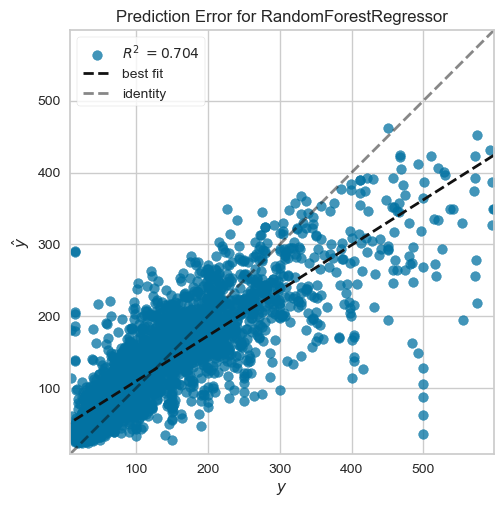

In [453]:
rf_visualizer = prediction_error(rf_gs.best_estimator_, X_train, y_train, X_test, y_test);

In [454]:
results_df = save_results(rf_gs, X_test, y_test, 'RF Todos los Barrios', results_df)
results_df.sort_values(by='Test Score', ascending=False)

,Test Score,R2 Score,Squared Error,Absolute Error
RF Todos los Barrios,0.693231,0.703783,2882.819490,34.113487
Random Forest,0.684072,0.722790,3225.703735,38.672822
Gradient Boosting,0.651285,0.692204,3581.609332,40.837924
SVM Regression with Kernel RBF,0.606702,0.647041,4107.139902,41.526226
K-Nearest Neighbors,0.564690,0.596415,4696.245006,46.505768
SVM cuadratico,0.561426,0.605028,4596.017360,42.988894
SVM lineal,0.490206,0.490278,5931.291293,48.466157


<Figure size 1000x500 with 0 Axes>

<BarContainer object of 38 artists>

Text(0.5, 0, 'Características')

Text(0, 0.5, 'Importancia de Permutación para k-NN')

Text(0.5, 1.0, 'Importancia de Permutación de Características para RF de todos los barrios')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

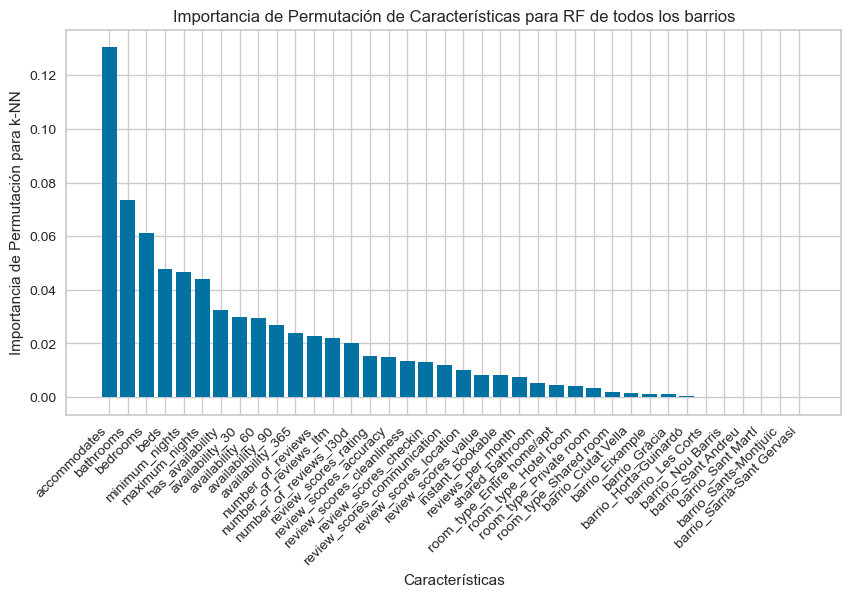

In [455]:
# Importancia de permutación para KNN
perm_importance_rf = permutation_importance(rf_gs, X_test, y_test, n_repeats=30, random_state=seed, n_jobs=-1)
perm_importance_rf_sort = importances = np.sort(perm_importance_rf['importances_mean'])[::-1]

# Visualización de la importancia de permutación para KNN
plt.figure(figsize=(10, 5))
plt.bar(X.columns, perm_importance_rf_sort)
plt.xlabel('Características')
plt.ylabel('Importancia de Permutación para k-NN')
plt.title('Importancia de Permutación de Características para RF de todos los barrios')
plt.xticks(rotation=45, ha='right')
plt.show()

# CONCLUSIÓN

ESP

En primera instancia, hemos decidido trabajar solo con el barrio de l'Eixample, ya que era el barrio con más inmuebles en la plataforma y no queríamos que el barrio supusiera un factor determinante en el resultado de los modelos. Cierto es que en la matriz de confusión podemos apreciar que no hay dependencia directa con el precio, pero de todas formas hemos preferido trabajar sobre un solo barrio, teniendo así la posibilidad de comparar el resultado con el entrenamiento sobre todas las muestras.

Hemos decidido eliminar los precios mayores a 600€ después de hacer pruebas con 1000, 800, 700 y 500; es la que mejor resultado ha dado.

En los anteriores experimentos hemos podido observar cómo el mejor resultado lo obtenemos a través del modelo Random Forest con un test score del 68% y del 69% para todos los inmuebles (con un valor inferior a 600€, más del 98% de las muestras). Podemos observar que los atributos menos determinantes son el barrio al que pertenecen los inmuebles, aunque ha tenido cierta importancia algunos.

Es posible que se pudiese mejorar el resultado usando otras técnicas; de todos modos, nos parece que llegar a un 70% de acierto sobre valores continuos en inmuebles de una misma ciudad de 100 km^2 (donde los precios no son tan distintos entre ellos) es un resultado satisfactorio.

ENG

Initially, we have decided to work only with the neighborhood of l'Eixample, as it was the neighborhood with the most properties on the platform, and we did not want the neighborhood to be a determining factor in the model's outcome. It is true that in the confusion matrix, we can see that there is no direct dependence on the price, but nonetheless, we preferred to work on only one neighborhood, thus having the possibility to compare the result with training on all samples.

We have decided to eliminate prices higher than 600€ after conducting tests with 1000, 800, 700, and 500; it is the one that has yielded the best result.

In the previous experiments, we have observed how the best result is achieved through the Random Forest model with a test score of 68% and 69% for all properties (with a value below 600€, more than 98% of the samples). We can observe that the least determinant attributes are the neighborhood to which the properties belong, although some have had certain importance.

It is possible that the result could be improved using other techniques; however, we believe that achieving a 70% accuracy on continuous values in properties within the same city of 100 km^2 (where prices are not so different among them) is a satisfactory result.
ChatGPT can make mistakes. Consider checking important information.